In [53]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [54]:
from fastbook import *
from fastai.vision.widgets import *
from pprint import pprint as pp

## Building bear classification system

#### Search for bear images in azure

In [55]:
key = os.environ.get('AZURE_SEARCH_KEY', '13cddac5c72149a3b1b7e70e2f7b1adb')

In [56]:
## fastai func to search images in bing engine
??search_images_bing

Signature: search_images_bing(key, term, min_sz=128, max_images=150)
Docstring: <no docstring>
Source:   
def search_images_bing(key, term, min_sz=128, max_images=150):
    params = dict(q=term, count=max_images, min_height=min_sz, min_width=min_sz)
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers={"Ocp-Apim-Subscription-Key":key}, params=params)
    response.raise_for_status()
    return L(response.json()['value'])
File:      ~/venv/faicu11/lib/python3.8/site-packages/fastbook/__init__.py
Type:      function


In [57]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [58]:
type(ims)

fastcore.foundation.L

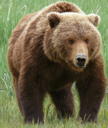

In [59]:
## es an example
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

dest= '/home/zimine/Pictures/fai/ch2/bears/example/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

#####  load few types of bears

In [60]:
bear_types = 'grizzly','black','teddy' #a tuple
type(bear_types)
# for o in bear_types:
#     print(f'type: {o}')

tuple

In [61]:
## set a topdir path for downloads
path = Path('/home/zimine/Pictures/fai/ch2/bears/downloaded')

In [62]:
pp(path)
pp(bear_types)
(path/bear_types[0])

Path('/home/zimine/Pictures/fai/ch2/bears/downloaded')
('grizzly', 'black', 'teddy')


Path('/home/zimine/Pictures/fai/ch2/bears/downloaded/grizzly')

In [63]:
#do the actual download
if not path.exists():
    path.mkdir()
#grizzly
bt=bear_types[0]
dest = (path/bt)
dest.mkdir(exist_ok=True)
# results = search_images_bing(key, f'{bt} bear')
# download_images(dest, urls=results.attrgot('contentUrl'))

In [64]:
##black
bt=bear_types[1]
dest = (path/bt)
dest.mkdir(exist_ok=True)
# results = search_images_bing(key, f'{bt} bear')
# download_images(dest, urls=results.attrgot('contentUrl'))

In [65]:
#teddy
bt=bear_types[2]
dest = (path/bt)
dest.mkdir(exist_ok=True)
# results = search_images_bing(key, f'{bt} bear')
# download_images(dest, urls=results.attrgot('contentUrl'))

In [66]:
#check dwnloaded files
fns = get_image_files(path)
print(type(fns))
pp(path)
pp(fns[:3])# .. first 3

<class 'fastcore.foundation.L'>
Path('/home/zimine/Pictures/fai/ch2/bears/downloaded')
[Path('/home/zimine/Pictures/fai/ch2/bears/downloaded/grizzly/00000149.jpg'), Path('/home/zimine/Pictures/fai/ch2/bears/downloaded/grizzly/00000117.jpg'), Path('/home/zimine/Pictures/fai/ch2/bears/downloaded/grizzly/00000140.jpg')]


In [67]:
#check for failed images
failed = verify_images(fns)
pp(len(failed))
failed

0


(#0) []

In [68]:
#this removes the failes imags from the directories!
failed.map(Path.unlink);

### Train bear type system

In [69]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [70]:
dls = bears.dataloaders(path)

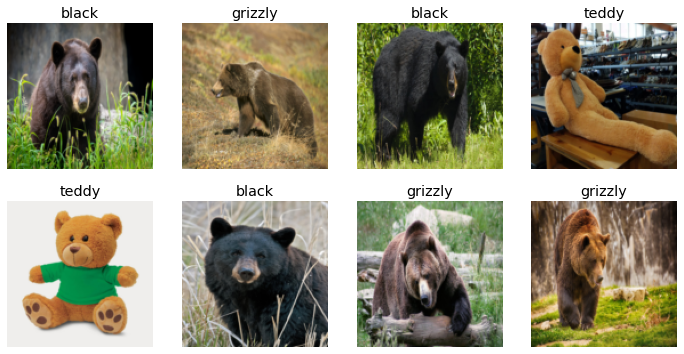

In [71]:
#example of transforms : squish
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

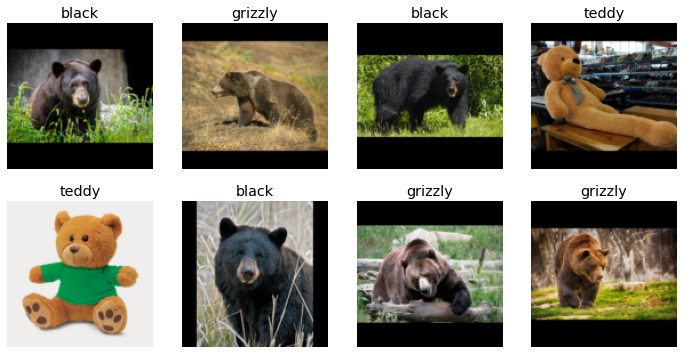

In [72]:
## image transforms padding
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

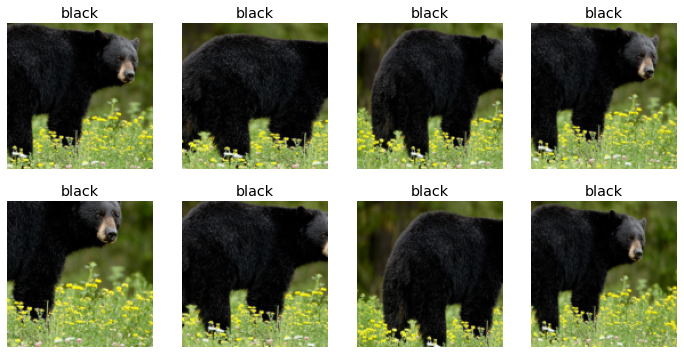

In [73]:
#transform randomResizedCrop  f
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)


### Train the model

In [74]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [75]:
learn = cnn_learner(dls, resnet18, metrics=error_rate) #default resnet18
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.473014,0.202304,0.087500,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.105829,0.057339,0.025000,00:13
1,0.103586,0.060433,0.012500,00:14
2,0.082530,0.051708,0.012500,00:14
3,0.066726,0.047327,0.012500,00:15
4,0.062779,0.045408,0.012500,00:14


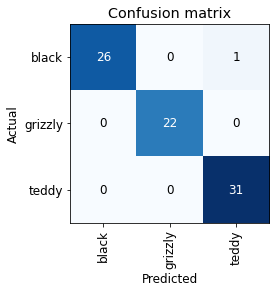

In [76]:
#confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


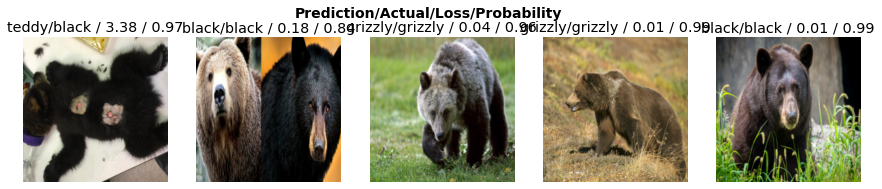

In [77]:
## images with top losses (least well classified)
interp.plot_top_losses(5, nrows=1)


#### fastai data cleaner


In [78]:
cleaner = ImageClassifierCleaner(learn)
cleaner


In [79]:
##for images marked for deletion run the following to delete them
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()

#to move images selected for another category run
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

#### run model to classify an image

In [80]:
pathpref='/home/zimine/Pictures/fai/ch2/topredict'

In [81]:
learn.predict(pathpref+'/grizzly/grizzly1.jpg')

('grizzly', tensor(1), tensor([0.0800, 0.9189, 0.0011]))

In [82]:
learn.predict(pathpref+'/grizzly/grizzly3.jpg')  #wrong

('grizzly', tensor(1), tensor([1.5452e-02, 9.8443e-01, 1.1903e-04]))

In [83]:
learn.predict(pathpref+'/black/black1.jpg')

('black', tensor(0), tensor([8.7221e-01, 1.2762e-01, 1.6770e-04]))

In [84]:
learn.predict(pathpref+'/teddy/teddy1.jpg')

('teddy', tensor(2), tensor([4.9813e-10, 6.5090e-09, 1.0000e+00]))

#### saving model to file

In [85]:
modelFile='/home/zimine/Pictures/fai/ch2/models/bear1.pkl'
learn.export(modelFile)

#### reading a model from file

In [86]:
learn_inf = load_learner(modelFile)


In [87]:
## use loaded model to classify an image
learn_inf.predict(pathpref+'/grizzly/grizzly1.jpg')


('grizzly', tensor(1), tensor([0.0800, 0.9189, 0.0011]))

### creating a notebook app

In [88]:
btn_upload = widgets.FileUpload()

In [89]:
out_pl = widgets.Output()
out_pl.clear_output()

In [90]:
lbl_pred = widgets.Label()


In [91]:
btn_run = widgets.Button(description='Classify')

In [92]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)


In [93]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])
